# Прогнозирование большого количества рядов

In [49]:
import pickle
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,8)

1. Составьте из данных о поездках прямоугольную таблицу так, чтобы по строкам было время, а по столбцам идентификатор ячейки (возьмите только те, которые были отобраны на второй неделе). Не используйте данные за последние имеющиеся месяцы — май и июнь 2016!

In [32]:
def load_pickle(pickle_file):
    try:
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f)
    except UnicodeDecodeError as e:
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f, encoding='latin1')
    except Exception as e:
        print('Unable to load data ', pickle_file, ':', e)
        raise
    return pickle_data

In [35]:
data = load_pickle('all_regions.pkl')
data

array([[ 87.,  92., 108., ..., 151., 106.,  85.],
       [146., 184., 165., ..., 162., 168., 130.],
       [ 70.,  93.,  55., ..., 145., 103.,  86.],
       ...,
       [106.,  87.,  39., ..., 213., 206., 173.],
       [ 22.,   0.,   0., ..., 142., 146., 119.],
       [ 71.,  44.,   1., ...,   1.,   0.,   0.]])

In [65]:
regions = []
for i in geo_json_data['features']:
    regions.append(int(i['id'])+1)

In [66]:
dates = pd.date_range('2014-01-01 00:00:00', periods=data.shape[1], freq='H')
df = pd.DataFrame(data.transpose(), index=dates, columns=regions)
df.head()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
2014-01-01 00:00:00,87.0,146.0,70.0,113.0,367.0,645.0,589.0,799.0,948.0,321.0,...,9.0,0.0,5.0,89.0,10.0,35.0,9.0,106.0,22.0,71.0
2014-01-01 01:00:00,92.0,184.0,93.0,153.0,539.0,604.0,490.0,635.0,667.0,225.0,...,24.0,0.0,3.0,22.0,2.0,5.0,0.0,87.0,0.0,44.0
2014-01-01 02:00:00,108.0,165.0,55.0,151.0,443.0,571.0,465.0,499.0,455.0,124.0,...,27.0,0.0,3.0,23.0,1.0,1.0,0.0,39.0,0.0,1.0
2014-01-01 03:00:00,77.0,108.0,32.0,112.0,372.0,533.0,442.0,370.0,307.0,101.0,...,57.0,0.0,0.0,3.0,2.0,1.0,0.0,5.0,1.0,0.0
2014-01-01 04:00:00,47.0,79.0,22.0,77.0,213.0,383.0,296.0,319.0,261.0,87.0,...,38.0,0.0,1.0,9.0,1.0,8.0,0.0,29.0,1.0,18.0


In [67]:
df.shape

(21888, 102)

уменьшим количество наблюдений для более удобной работы

In [69]:
df = df.loc['2016-04-01 00:00:00':'2016-04-30 23:00:00']

2. Перед проведением кластеризации стандартизуйте столбцы (вычтите выборочное среднее и поделите на выборочную дисперсию). Это необходимо, поскольку при выборе модели ARIMA имеет значение только форма ряда, но не его средний уровень и размах колебаний.



In [70]:
from sklearn.preprocessing import StandardScaler

In [ ]:
>>> from sklearn.preprocessing import StandardScaler
>>> data = [[0, 0], [0, 0], [1, 1], [1, 1]]
>>> scaler = StandardScaler()
>>> print(scaler.fit(data))
StandardScaler()
>>> print(scaler.mean_)
[0.5 0.5]
>>> print(scaler.transform(data))
[[-1. -1.]
 [-1. -1.]
 [ 1.  1.]
 [ 1.  1.]]
>>> print(scaler.transform([[2, 2]]))
[[3. 3.]]

In [73]:
scaler = StandardScaler()
df_new = pd.DataFrame(scaler.fit_transform(df), columns = df.columns, index = df.index)
df_new.head()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
2016-04-01 00:00:00,-0.515019,-1.031047,-0.999806,-0.047065,-0.243865,0.090873,1.221386,1.180456,1.179130,0.316922,...,-0.234588,-0.924545,-0.790592,-0.311499,-0.923175,0.237511,0.515829,0.486176,0.854275,0.858703
2016-04-01 01:00:00,-1.035163,-1.163537,-1.246812,-0.583333,-1.050387,-0.414204,0.091729,0.367868,0.705762,-0.238034,...,0.569713,-0.924545,-0.263775,-1.358649,-1.181507,-0.397122,0.515829,0.355165,-0.676341,0.100493
2016-04-01 02:00:00,-1.357157,-1.416473,-1.296214,-1.247283,-1.369013,-0.989431,-0.761278,-0.298746,0.541287,-1.153711,...,0.770789,-0.924545,-1.317410,-1.378916,-1.295476,-1.237581,-1.006810,-1.465878,-1.173792,-1.551323
2016-04-01 03:00:00,-1.456232,-1.585097,-1.444418,-1.247283,-1.627897,-1.024506,-1.377979,-0.955629,0.304603,-1.195332,...,-0.234588,-0.924545,-0.790592,-1.378916,-1.303074,-1.546321,-1.260583,-1.727899,-1.173792,-1.713796
2016-04-01 04:00:00,-1.431464,-1.536918,-1.444418,-1.349429,-1.617940,-1.206895,-1.464432,-1.125932,-0.734400,-1.625423,...,0.569713,-0.849548,-0.527184,-1.358649,-1.287878,-1.529169,-1.260583,-1.675495,-1.173792,-1.713796


3. Кластеризуйте географические зоны по значениям стандартизованных рядов. Подберите число кластеров так, чтобы оно было не слишком большим, но ряды внутри кластеров имели похожую форму. Постройте графики стандартизованных рядов каждого кластера, чтобы в этом убедиться.



In [74]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy

Для начала проведем иерархическую кластеризацию и оценим результат

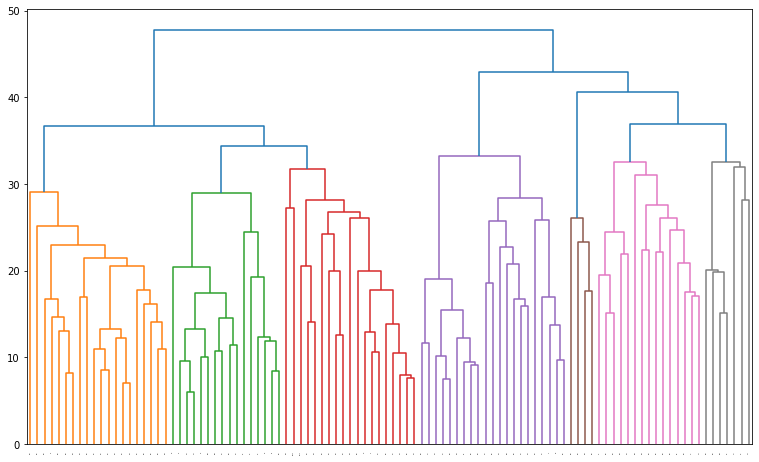

In [93]:
mergings1 = linkage(df_new.transpose().to_numpy(), method='complete') 
fig = plt.figure(figsize=(13, 8))
result = dendrogram(mergings1,leaf_font_size=2) 
plt.show()

В результате иерархической кластеризации было выделено 7 класеров

Чтобы убедиться в полученном результате построим график "локтя"

In [79]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [ ]:
# Объект, в котором будет хранится информация о последовательном слиянии кластеров
link = linkage(df_new.transpose(), 'ward', 'euclidean')

In [ ]:
K = range(1, 11)
models = [KMeans(n_clusters=k, random_state=42).fit(df) for k in K]
dist = [model.inertia_ for model in models]

# Plot the elbow
plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.ylabel('Sum of distances')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [82]:
dist = link[:, 2]

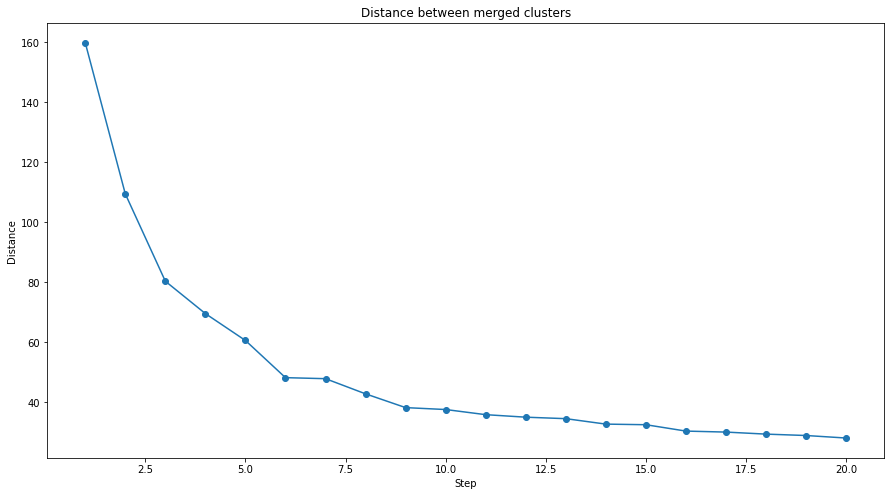

In [91]:
dist_rev = dist[::-1]
idxs = range(1, len(dist) + 1)
plt.plot(idxs[:20], dist_rev[:20], marker='o')
plt.title('Distance between merged clusters')
plt.xlabel('Step')
plt.ylabel('Distance')
plt.show()

Из графика видно, что оптимальное число кластеров 6-7, так как после этих значений межкластерное расстояние наченает уменьшаться гораздо медленнее 

4. В каждом кластере выберите наиболее типичный ряд (например, это может быть ряд, соответствующий центру кластера).



Добавим метки кластеров в исходный dataframe

In [100]:
df_transp = df_new.transpose()
df_transp.head()

,2016-04-01 00:00:00,2016-04-01 01:00:00,2016-04-01 02:00:00,2016-04-01 03:00:00,2016-04-01 04:00:00,2016-04-01 05:00:00,2016-04-01 06:00:00,2016-04-01 07:00:00,2016-04-01 08:00:00,2016-04-01 09:00:00,...,2016-04-30 14:00:00,2016-04-30 15:00:00,2016-04-30 16:00:00,2016-04-30 17:00:00,2016-04-30 18:00:00,2016-04-30 19:00:00,2016-04-30 20:00:00,2016-04-30 21:00:00,2016-04-30 22:00:00,2016-04-30 23:00:00
1075,-0.515019,-1.035163,-1.357157,-1.456232,-1.431464,-1.481001,-1.258082,-0.589325,0.079432,-0.193025,...,1.763709,1.937091,2.358160,1.862785,2.234316,1.342640,0.995877,0.599577,0.822496,0.624345
1076,-1.031047,-1.163537,-1.416473,-1.585097,-1.536918,-1.356250,-0.778112,0.161364,0.920170,0.775636,...,2.136670,1.907824,0.884037,1.124928,0.992438,0.823814,0.811769,0.173408,-0.525176,-0.272240
1077,-0.999806,-1.246812,-1.296214,-1.444418,-1.444418,-1.296214,-0.719865,0.893913,1.783137,0.877446,...,0.860979,0.910380,0.334031,0.317564,0.531636,0.877446,0.119958,0.268162,-0.110581,-0.472858
1125,-0.047065,-0.583333,-1.247283,-1.247283,-1.349429,-1.272820,-0.685479,0.208300,0.872250,0.310446,...,0.565812,0.565812,0.157227,0.719031,1.076543,0.821177,0.974397,1.178689,0.795641,0.438129
1126,-0.243865,-1.050387,-1.369013,-1.627897,-1.617940,-1.319228,-0.801461,-0.452963,0.413301,0.283859,...,0.931068,0.911154,0.682142,1.359222,1.428922,1.488664,0.941026,1.219823,0.214160,0.881283


In [101]:
df_transp['cluster'] = fcluster(link, 50, criterion='distance')

В качестве типичного ряда кластера, выберем усредненный ряд из всех регионов, попавших в данный кластер 

In [104]:
df_cluser = df_transp.groupby('cluster').mean()

In [106]:
df_cluser

,2016-04-01 00:00:00,2016-04-01 01:00:00,2016-04-01 02:00:00,2016-04-01 03:00:00,2016-04-01 04:00:00,2016-04-01 05:00:00,2016-04-01 06:00:00,2016-04-01 07:00:00,2016-04-01 08:00:00,2016-04-01 09:00:00,...,2016-04-30 14:00:00,2016-04-30 15:00:00,2016-04-30 16:00:00,2016-04-30 17:00:00,2016-04-30 18:00:00,2016-04-30 19:00:00,2016-04-30 20:00:00,2016-04-30 21:00:00,2016-04-30 22:00:00,2016-04-30 23:00:00
cluster,,,,,,,,,,,,,,,,,,,,,
1,-0.881914,-1.122034,-1.325908,-1.423173,-1.453786,-1.209609,-0.474788,0.753706,1.245893,0.806456,...,0.719847,0.640570,0.486868,0.674817,0.926696,0.985465,0.447449,0.154060,0.124757,0.115852
2,0.122742,-0.677035,-1.172795,-1.403795,-1.496563,-1.446797,-0.855953,-0.069065,0.454361,0.332577,...,0.387631,0.401983,0.154983,0.495876,0.896030,1.122143,0.825735,0.942213,1.159138,1.232034
3,-0.064366,-0.496853,-1.261274,-1.314200,-1.269857,-1.051921,-0.629113,-0.293077,-0.104753,-0.278003,...,0.224744,0.416170,0.145398,0.687057,-0.002627,0.031326,0.070039,0.253925,0.081863,-0.092975
4,0.839121,0.445973,0.100127,-0.306043,-0.650759,-0.840734,-0.530268,-0.218228,-0.138811,-0.158350,...,0.192427,0.070518,-0.019226,0.240309,0.476993,0.725995,0.684738,1.255641,1.916512,2.725109
5,0.014074,-0.331361,-0.818088,-0.946969,-0.832224,-0.662911,0.618057,2.454428,2.181148,0.274640,...,0.209106,-0.080941,0.138872,0.481357,0.657007,0.462526,0.319469,0.762641,0.429257,1.290473
6,-0.130864,-0.187177,-0.104009,-0.438237,0.369551,0.055610,0.944081,1.359332,1.199029,0.376687,...,-0.314708,-0.046932,-0.441991,-0.173203,-0.221939,-0.368975,-0.253959,-0.156864,-0.296065,0.652196


Изобразим 6 полученных рядов:

<AxesSubplot:>

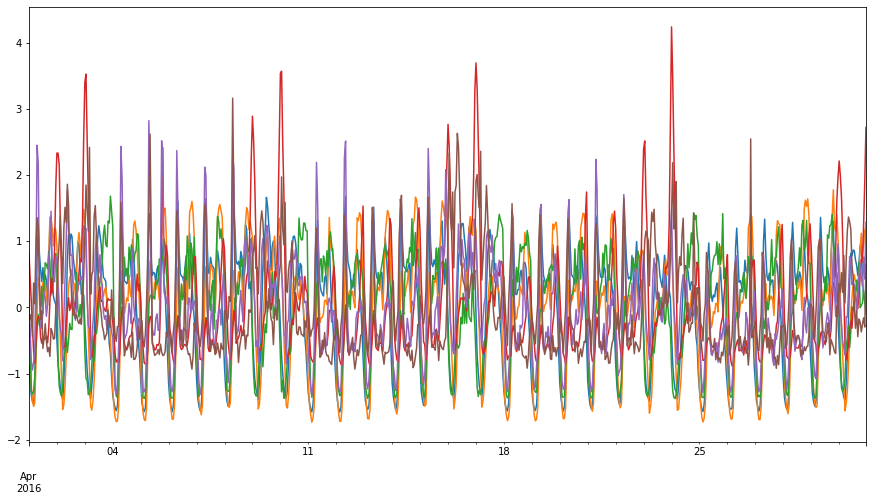

In [111]:
df_cluser.iloc[0].plot()
df_cluser.iloc[1].plot()
df_cluser.iloc[2].plot()
df_cluser.iloc[3].plot()
df_cluser.iloc[4].plot()
df_cluser.iloc[5].plot()

5. Для выбранных географических зон подберите на исходных рядах оптимальную структуру моделей — набор регрессионных признаков и значения гиперпараметров p,d,q,P,D,Q — так, как это делалось на прошлой неделе. Не используйте данные за последний имеющийся месяц — май и июнь 2016!



6. Для каждой из R географических зон настройте на данных до апреля 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 постройте прогноз на 6 часов вперёд и посчитайте в ноутбуке ошибку прогноза по следующему функционалу: 



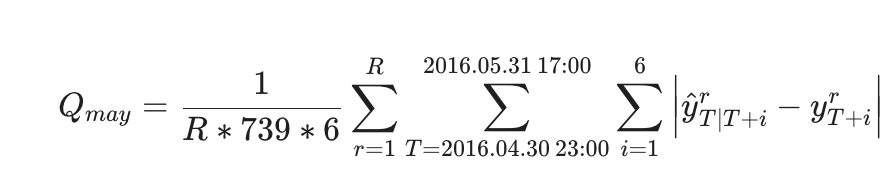

7. Для каждой из  R географических зон настройте на данных до мая 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 постройте прогноз на 6 часов вперёд и запишите все прогнозы в файл в формате id,y, где столбец id состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец y — ваш прогноз.

